# Классификация кредитных рейтингов

## Словесное описание задачи

На основе сведений о человеке (личная информация, работа, ) рассчитать кредитный рейтинг.

## Чтение данных

Установим и импортируем необходимые для работы библиотеки.

In [1]:
%pip install numpy matplotlib pandas scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from sklearn.model_selection import KFold
%matplotlib inline

Датасет уже предоставляется с разбиением на обучающий и тестовый наборы. В целях анализа датасета и его обработки, два набора объединяются в один.

In [3]:
df = pd.read_csv('./train.csv')
df.head()

/tmp/ipykernel_125444/1949314583.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./train.csv')


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


## Визуализация данных и основные характеристики

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,84998.0,4194.170850,3183.686167,303.645417,1625.568229,3093.745000,5957.448333,15204.633333
Num_Bank_Accounts,100000.0,17.091280,117.404834,-1.000000,3.000000,6.000000,7.000000,1798.000000
Num_Credit_Card,100000.0,22.474430,129.057410,0.000000,4.000000,5.000000,7.000000,1499.000000
Interest_Rate,100000.0,72.466040,466.422621,1.000000,8.000000,13.000000,20.000000,5797.000000
Delay_from_due_date,100000.0,21.068780,14.860104,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_Credit_Inquiries,98035.0,27.754251,193.177339,0.000000,3.000000,6.000000,9.000000,2597.000000
Credit_Utilization_Ratio,100000.0,32.285173,5.116875,20.000000,28.052567,32.305784,36.496663,50.000000
Total_EMI_per_month,100000.0,1403.118217,8306.041270,0.000000,30.306660,69.249473,161.224249,82331.000000


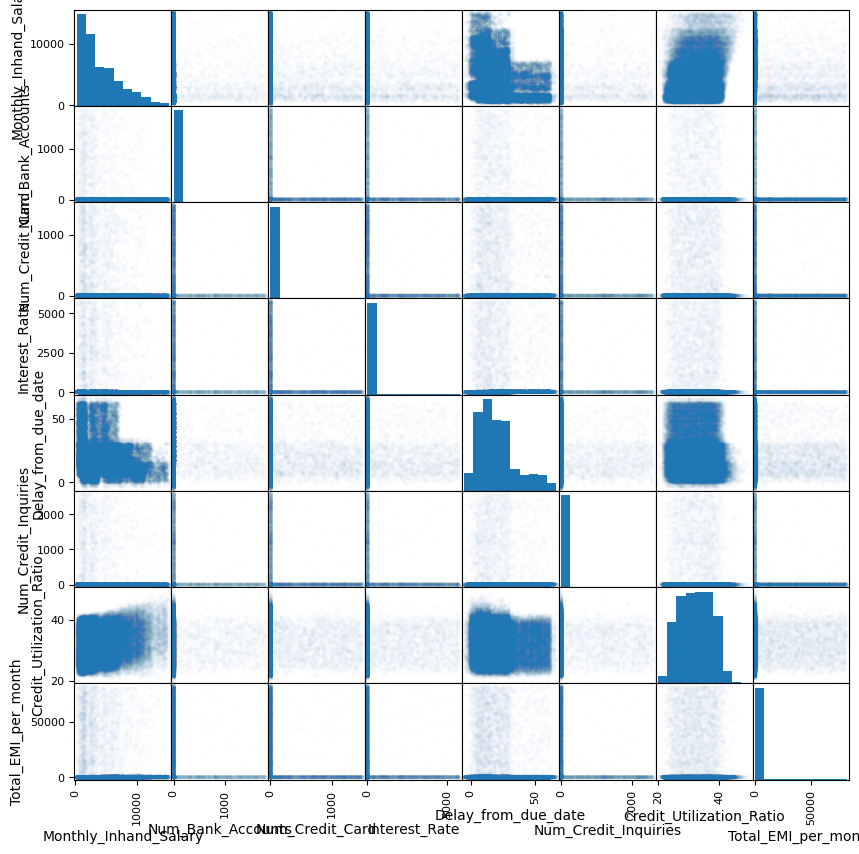

In [5]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.01, figsize=(10, 10))
pass

## Обработка пропущенных значений и выбросов

Особенностью рассматриваемого датасета является характер содержащихся в нём данных: информация о всяком клиенте предоставлена по каждому месяцу, с января по август. Это позволяет более разумно заполнять пропущенные значения или исправлять выбросы --- средние значения и моды будут браться не по всей выборке, а по каждому из клиентов.

In [6]:
df_clean = df.copy()

### Вспомогательные функции

In [7]:
def get_group_min_max(df, groupby, column):
    """
    Группирует предоставленный df по groupby, затем находит
    во всякой группе моду, а затем возвращает наименьшее и
    наибольшее значение мод. Используется для оценки истинных
    границ значений по столбцу.
    """

    cur = df[df[column].notna()].groupby(groupby)[column].apply(list)
    x, y = cur.apply(lambda x: stats.mode(x)).apply([min, max])
    return x[0], y[0]


def age_to_months(string):
    """
    Переводит словесное описание периода времени (лет + месяцев) в
    эквивалентное численное значение месяцев
    """

    if pd.isna(string):
        return pd.NA
    years, months = map(int, [string.split()[0], string.split()[-2]])
    return years * 12 + months

### Нерелевантные столбцы

Из выборки будут удалены столбы "ID", "Name" и "SSN", так как они не представляют никакой ценности в расчётах кредитного рейтинга.

In [8]:
df_clean = df_clean.drop(columns=["ID", "Name", "SSN"])

### `Age`

In [9]:
df_clean['Age'] = df_clean['Age'].str.rstrip('_').astype('int64')
mini, maxi = get_group_min_max(df_clean, 'Customer_ID', 'Age')
df_clean['Age'] = df_clean['Age'].transform(lambda x: x if mini - 1 <= x <= maxi + 1 else pd.NA)
df_clean['Age'] = df_clean.groupby('Customer_ID')['Age'].transform(lambda x: x.fillna(x.mode()[0]))

/tmp/ipykernel_125444/3632480628.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['Age'] = df_clean.groupby('Customer_ID')['Age'].transform(lambda x: x.fillna(x.mode()[0]))


### `Occupation`

In [10]:
df_clean['Occupation'] = df_clean['Occupation'].replace('_______', pd.NA)
df_clean['Occupation'] = df_clean.groupby('Customer_ID')['Occupation'].transform(lambda x: x.fillna(x.mode()[0]))

### `Annual_Income`

In [11]:
df_clean['Annual_Income'] = df_clean['Annual_Income'].str.rstrip('_').astype('float64')
median = df_clean['Annual_Income'].median()
mad = np.median(np.abs(df_clean['Annual_Income'] - median))
z_scores = 0.6745 * (df_clean['Annual_Income'] - median) / mad
outliers = np.abs(z_scores) > 5
def replace_outliers(x):
    m = x[~outliers[x.index]].mean()
    x.loc[outliers[x.index]] = m
    return x
df_clean['Annual_Income'] = df_clean.groupby('Customer_ID')['Annual_Income'].transform(replace_outliers)

### `Monthly_Inhand_Salary`

In [12]:
df_clean['Monthly_Inhand_Salary'] = df_clean.groupby('Customer_ID')['Monthly_Inhand_Salary'].transform(lambda x: x.fillna(x.mean()))

### `Num_Bank_Accounts`

In [13]:
mini, maxi = get_group_min_max(df_clean, 'Customer_ID', 'Num_Bank_Accounts')
df_clean['Num_Bank_Accounts'] = df_clean['Num_Bank_Accounts'].transform(lambda x: x if mini - 1 <= x <= maxi + 1 else pd.NA)
df_clean['Num_Bank_Accounts'] = df_clean.groupby('Customer_ID')['Num_Bank_Accounts'].transform(lambda x: x.fillna(x.mode()[0]))

/tmp/ipykernel_125444/2448251021.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['Num_Bank_Accounts'] = df_clean.groupby('Customer_ID')['Num_Bank_Accounts'].transform(lambda x: x.fillna(x.mode()[0]))


### `Num_Credit_Card`

In [14]:
mini, maxi = get_group_min_max(df_clean, 'Customer_ID', 'Num_Credit_Card')
df_clean['Num_Credit_Card'] = df_clean['Num_Credit_Card'].transform(lambda x: x if mini - 1 <= x <= maxi + 1 else pd.NA)
df_clean['Num_Credit_Card'] = df_clean.groupby('Customer_ID')['Num_Credit_Card'].transform(lambda x: x.fillna(x.mode()[0]))

/tmp/ipykernel_125444/3319832763.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['Num_Credit_Card'] = df_clean.groupby('Customer_ID')['Num_Credit_Card'].transform(lambda x: x.fillna(x.mode()[0]))


### `Interest_Rate`

In [15]:
mini, maxi = get_group_min_max(df_clean, 'Customer_ID', 'Interest_Rate')
df_clean['Interest_Rate'] = df_clean['Interest_Rate'].transform(lambda x: x if mini - 1 <= x <= maxi + 1 else pd.NA)
df_clean['Interest_Rate'] = df_clean.groupby('Customer_ID')['Interest_Rate'].transform(lambda x: x.fillna(x.mode()[0]))

/tmp/ipykernel_125444/1943436564.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['Interest_Rate'] = df_clean.groupby('Customer_ID')['Interest_Rate'].transform(lambda x: x.fillna(x.mode()[0]))


### `Num_of_Loan`

In [16]:
df_clean['Num_of_Loan'] = df_clean['Num_of_Loan'].str.rstrip('_').astype('int64')
mini, maxi = get_group_min_max(df_clean, 'Customer_ID', 'Num_of_Loan')
df_clean['Num_of_Loan'] = df_clean['Num_of_Loan'].transform(lambda x: x if mini - 1 <= x <= maxi + 1 else pd.NA)
df_clean['Num_of_Loan'] = df_clean.groupby('Customer_ID')['Num_of_Loan'].transform(lambda x: x.fillna(x.mode()[0]))

/tmp/ipykernel_125444/1786098755.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['Num_of_Loan'] = df_clean.groupby('Customer_ID')['Num_of_Loan'].transform(lambda x: x.fillna(x.mode()[0]))


### `Num_of_Delayed_Payment`

In [17]:
df_clean['Num_of_Delayed_Payment'] = df_clean['Num_of_Delayed_Payment'].str.rstrip('_')
df_clean['Num_of_Delayed_Payment'] = df_clean.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(lambda x: x.fillna(x.mode()[0])).astype('int64')
mini, maxi = get_group_min_max(df_clean, 'Customer_ID', 'Num_of_Delayed_Payment')
df_clean['Num_of_Delayed_Payment'] = df_clean['Num_of_Delayed_Payment'].transform(lambda x: x if mini - 1 <= x <= maxi + 1 else pd.NA)
df_clean['Num_of_Delayed_Payment'] = df_clean.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(lambda x: x.fillna(x.mode()[0]))

/tmp/ipykernel_125444/2790564540.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['Num_of_Delayed_Payment'] = df_clean.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(lambda x: x.fillna(x.mode()[0]))


### `Changed_Credit_Limit`

In [18]:
df_clean['Changed_Credit_Limit'] = pd.to_numeric(df_clean['Changed_Credit_Limit'], errors='coerce')
df_clean['Changed_Credit_Limit'] = df_clean.groupby('Customer_ID')['Changed_Credit_Limit'].transform(lambda x: x.fillna(x.mean()))

### `Num_Credit_Inquiries`

In [19]:
df_clean['Num_Credit_Inquiries'] = df_clean.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(lambda x: x.fillna(x.mode()[0])).astype('int64')
mini, maxi = get_group_min_max(df_clean, 'Customer_ID', 'Num_Credit_Inquiries')
df_clean['Num_Credit_Inquiries'] = df_clean['Num_Credit_Inquiries'].transform(lambda x: x if mini - 1 <= x <= maxi + 1 else pd.NA)
df_clean['Num_Credit_Inquiries'] = df_clean.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(lambda x: x.fillna(x.mode()[0]))

/tmp/ipykernel_125444/544525516.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['Num_Credit_Inquiries'] = df_clean.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(lambda x: x.fillna(x.mode()[0]))


### `Credit_Mix`

In [20]:
df_clean['Credit_Mix'] = df_clean['Credit_Mix'].transform(lambda x: pd.NA if x == '_' else x)
df_clean['Credit_Mix'] = df_clean.groupby('Customer_ID')['Credit_Mix'].transform(lambda x: x.fillna(x.mode()[0]))

### `Outstanding_Debt`

In [21]:
df_clean['Outstanding_Debt'] = df_clean['Outstanding_Debt'].str.rstrip('_').astype('float64')

### `Total_EMI_per_month`

In [22]:
mini, maxi = get_group_min_max(df_clean, 'Customer_ID', 'Total_EMI_per_month')
df_clean['Total_EMI_per_month'] = df_clean['Total_EMI_per_month'].transform(lambda x: x if mini - 1 <= x <= maxi + 1 else pd.NA)
df_clean['Total_EMI_per_month'] = df_clean.groupby('Customer_ID')['Total_EMI_per_month'].transform(lambda x: x.fillna(x.mean()))

/tmp/ipykernel_125444/3736980660.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['Total_EMI_per_month'] = df_clean.groupby('Customer_ID')['Total_EMI_per_month'].transform(lambda x: x.fillna(x.mean()))


### `Amount_invested_monthly`

In [23]:
df_clean['Amount_invested_monthly'] = pd.to_numeric(df_clean['Amount_invested_monthly'], errors='coerce')
df_clean['Amount_invested_monthly'] = df_clean.groupby('Customer_ID')['Amount_invested_monthly'].transform(lambda x: x.fillna(x.mean()))

### `Monthly_Balance`

In [24]:
df_clean['Monthly_Balance'] = pd.to_numeric(df_clean['Monthly_Balance'], errors='coerce')
df_clean['Monthly_Balance'] = df_clean.groupby('Customer_ID')['Monthly_Balance'].transform(lambda x: x.fillna(x.mean()))

### `Payment_Behaviour`

In [25]:
df_clean['Payment_Behaviour'] = df_clean['Payment_Behaviour'].transform(lambda x: pd.NA if x == '!@9#%8' else x)
df_clean['Payment_Behaviour'] = df_clean.groupby('Customer_ID')['Payment_Behaviour'].transform(lambda x: x.fillna(x.mode()[0]))

### `Credit_History_Age`

In [26]:
df_clean['Credit_History_Age'] = pd.to_numeric(df_clean['Credit_History_Age'].transform(age_to_months), errors='coerce')
df_clean['Credit_History_Age'] = df_clean.groupby('Customer_ID')['Credit_History_Age'].transform(lambda x: x.interpolate('linear', limit_direction='both').round())

### `Type_of_Loan`

In [27]:
df_clean['Type_of_Loan'] = df_clean['Type_of_Loan'].apply(lambda x: x.lower().replace('and ', '').replace(', ', ',').strip() if pd.notna(x) else x)
df_clean['Type_of_Loan'] = df_clean['Type_of_Loan'].replace([pd.NA], 'no loan')

### Итого

После обработки значений столбец `Customer_ID` может быть убран, так как никакой ценности для решения задачи он не несёт.

In [28]:
df_clean = df_clean.drop(columns=["Customer_ID"])

In [29]:
df_clean.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,January,23,Scientist,19114.12,1824.843333,3,4,3,4,"auto loan,credit-builder loan,personal loan,ho...",...,Good,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,February,23,Scientist,19114.12,1824.843333,3,4,3,4,"auto loan,credit-builder loan,personal loan,ho...",...,Good,809.98,31.944960,266.0,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,March,23,Scientist,19114.12,1824.843333,3,4,3,4,"auto loan,credit-builder loan,personal loan,ho...",...,Good,809.98,28.609352,267.0,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,April,23,Scientist,19114.12,1824.843333,3,4,3,4,"auto loan,credit-builder loan,personal loan,ho...",...,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,May,23,Scientist,19114.12,1824.843333,3,4,3,4,"auto loan,credit-builder loan,personal loan,ho...",...,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good


In [30]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,100000.0,33.311180,10.764783,14.000000,24.000000,33.000000,42.000000,56.000000
Annual_Income,100000.0,50505.123449,38299.422093,7005.930000,19342.972500,36999.705000,71683.470000,179987.280000
Monthly_Inhand_Salary,100000.0,4198.468568,3187.369878,303.645417,1626.594167,3096.378333,5961.637500,15204.633333
Num_Bank_Accounts,100000.0,5.368630,2.593748,-1.000000,3.000000,5.000000,7.000000,11.000000
Num_Credit_Card,100000.0,5.533680,2.067126,0.000000,4.000000,5.000000,7.000000,11.000000
Interest_Rate,100000.0,14.532080,8.741330,1.000000,7.000000,13.000000,20.000000,34.000000
Num_of_Loan,100000.0,3.532880,2.446356,0.000000,2.000000,3.000000,5.000000,9.000000
Delay_from_due_date,100000.0,21.068780,14.860104,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_of_Delayed_Payment,100000.0,13.310540,6.302706,-3.000000,9.000000,14.000000,18.000000,28.000000
Changed_Credit_Limit,100000.0,10.388537,6.784097,-6.490000,5.340000,9.400000,14.850000,36.970000


In [31]:
# scatter_matrix(df_clean, alpha=0.01, figsize=(10, 10))
pass

## Нормализация

In [50]:
df_numeric = df_clean.copy()

In [ ]:
numeric_columns = df_numeric.select_dtypes(include=['int', 'float']).columns.to_list()
for column in numeric_columns:
    df_numeric[column] = (df_numeric[column] - df_numeric[column].mean()) / df_numeric[column].std()

## Обработка категориальных признаков

### `Month`

In [52]:
df_numeric.groupby('Month').size()

Month
April       12500
August      12500
February    12500
January     12500
July        12500
June        12500
March       12500
May         12500
dtype: int64

In [60]:
df_numeric = df_numeric.replace(
    {
        'Month': {
            'January': 0,
            'February': 1,
            'March': 2,
            'April': 3,
            'May': 4,
            'June': 5,
            'July': 6,
            'August': 7,
        }
    }
)
df_numeric['Month'] = (df_numeric['Month'] - df_numeric['Month'].mean()) / df_numeric['Month'].std()

### `Credit_Score`

In [54]:
df_numeric = df_numeric.replace(
    {
        'Credit_Score': {
            'Poor': 0,
            'Standard': 1,
            'Good': 2,
        }
    }
)

/tmp/ipykernel_125444/935249186.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_numeric = df_numeric.replace(


### `Occupation`

In [55]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
df_numeric['Occupation_enc'] = 0

for train_idx, valid_idx in kf.split(df_numeric):
    train, valid = df_numeric.iloc[train_idx], df_numeric.iloc[valid_idx]
    means = train.groupby('Occupation')['Credit_Score'].mean()
    df_numeric.loc[valid_idx, 'Occupation_enc'] = valid['Occupation'].map(means).fillna(df_numeric['Credit_Score'].mean())

df_numeric['Occupation_enc'] += np.random.normal(0, 0.001, df_numeric['Occupation_enc'].shape)
df_numeric['Occupation'] = df_numeric['Occupation_enc']
df_numeric = df_numeric.drop(columns=['Occupation_enc'])

/tmp/ipykernel_125444/1453003964.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.87929732 0.87837094 0.89758924 ... 0.91107872 0.85530965 0.85530965]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_numeric.loc[valid_idx, 'Occupation_enc'] = valid['Occupation'].map(means).fillna(df_numeric['Credit_Score'].mean())


### `Type_of_Loan`

In [56]:
loan_types = set()
df_numeric['Type_of_Loan'].str.split(',').apply(loan_types.update)

for loan in loan_types:
    df_numeric[loan.replace(' ', '_')] = df_numeric['Type_of_Loan'].transform(lambda x: 1 if loan in x.split(',') else 0)

df_numeric = df_numeric.drop(columns=['Type_of_Loan'])

### `Credit_Mix`

In [57]:
df_numeric = df_numeric.replace(
    {
        'Credit_Mix': {
            'Bad': 0,
            'Standard': 1,
            'Good': 2,
        }
    }
)

/tmp/ipykernel_125444/133177589.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_numeric = df_numeric.replace(


### `Payment_of_Min_Amount`

In [58]:
df_numeric = df_numeric.replace(
    {
        'Payment_of_Min_Amount': {
            'No': 0,
            'NM': 1,
            'Yes': 2,
        }
    }
)

/tmp/ipykernel_125444/3387600217.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_numeric = df_numeric.replace(


### `Payment_Behaviour`

In [59]:
split = df_numeric['Payment_Behaviour'].str.split('_', expand=True)
df_numeric['Payment_Behaviour_Spent'] = split[0]
df_numeric['Payment_Behaviour_Payments'] = split[2]

df_numeric = df_numeric.replace(
    {
        'Payment_Behaviour_Spent': {
            'Low': 0,
            'High': 1,
        },
        'Payment_Behaviour_Payments': {
            'Small': 0,
            'Medium': 1,
            'Large': 2,
        }
    }
)
df_numeric = df_numeric.drop(columns=['Payment_Behaviour'])

/tmp/ipykernel_125444/963526755.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_numeric = df_numeric.replace(


## Разбиение на обучающую и тестовую выборки

In [63]:
from sklearn.model_selection import train_test_split

X = df_numeric.drop('Credit_Score', axis=1).to_numpy()
y = df_numeric['Credit_Score'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Обучение

### kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76      7313
           1       0.77      0.80      0.78     13265
           2       0.68      0.58      0.63      4422

    accuracy                           0.75     25000
   macro avg       0.73      0.71      0.72     25000
weighted avg       0.75      0.75      0.75     25000



In [67]:
confusion_matrix(y_test, knn_y_pred)

array([[ 5647,  1432,   234],
       [ 1771, 10547,   947],
       [  194,  1678,  2550]])

#### Подбор оптимального `k`

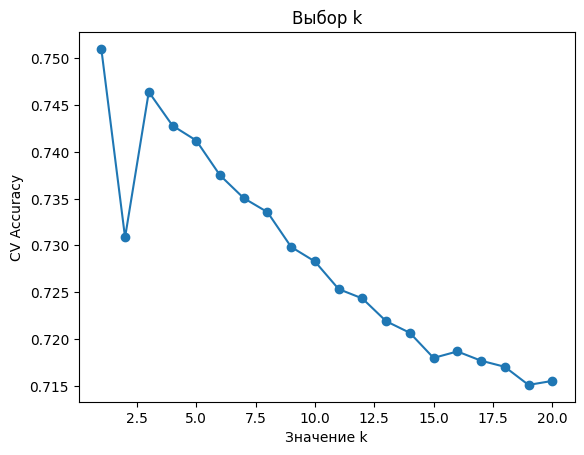

In [ ]:
from sklearn.model_selection import cross_val_score

k_values = list(range(1, 21))
cv_scores = [ cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train, y_train, scoring='accuracy').mean() for k in k_values ]

plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Значение k')
plt.ylabel('Кросс-валидация, точность')
plt.title('Выбор k')
plt.show()

Рассмотрим работу при $k = 3$:

In [69]:
opt_knn = KNeighborsClassifier(n_neighbors=3)
opt_knn.fit(X_train, y_train)
opt_knn_y_pred = opt_knn.predict(X_test)

In [70]:
print(classification_report(y_test, opt_knn_y_pred))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      7313
           1       0.81      0.78      0.80     13265
           2       0.71      0.67      0.69      4422

    accuracy                           0.77     25000
   macro avg       0.75      0.75      0.75     25000
weighted avg       0.77      0.77      0.77     25000



In [71]:
confusion_matrix(y_test, opt_knn_y_pred)

array([[ 5781,  1377,   155],
       [ 1793, 10408,  1064],
       [  335,  1121,  2966]])